# Hub'Eau time series univariate forecasting

Setup our working environment first in order to be able to visualise data and make training/prediction:

In [7]:
import sys
sys.path.append('..')

# This ensures that modules are reloaded while developing
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data processing

Read raw data from a station to be used for training the model and display it:

array([<AxesSubplot:xlabel='date_obs'>], dtype=object)

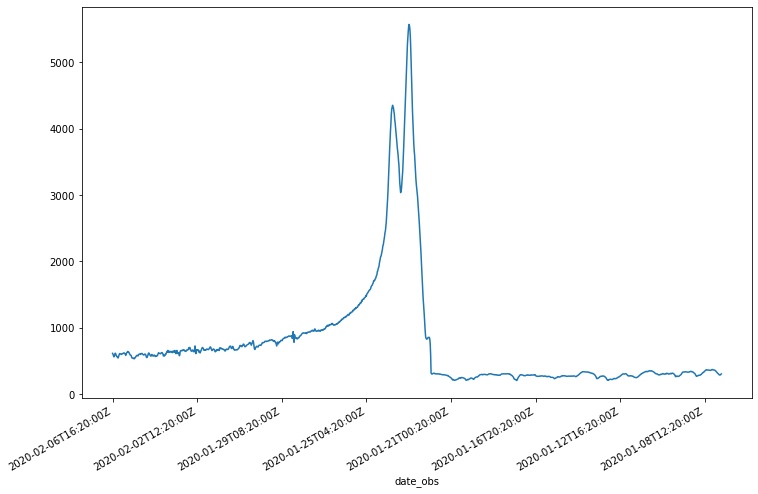

In [15]:
from src.data import read_raw_data

data = read_raw_data("../data/raw/train_data/hubeau_site_Y1422030_30d_30m_L'Aude.csv")
data.plot(subplots=True)

Read data from a station at a different time period to be used for validating the model and display it:

array([<AxesSubplot:xlabel='date_obs'>], dtype=object)

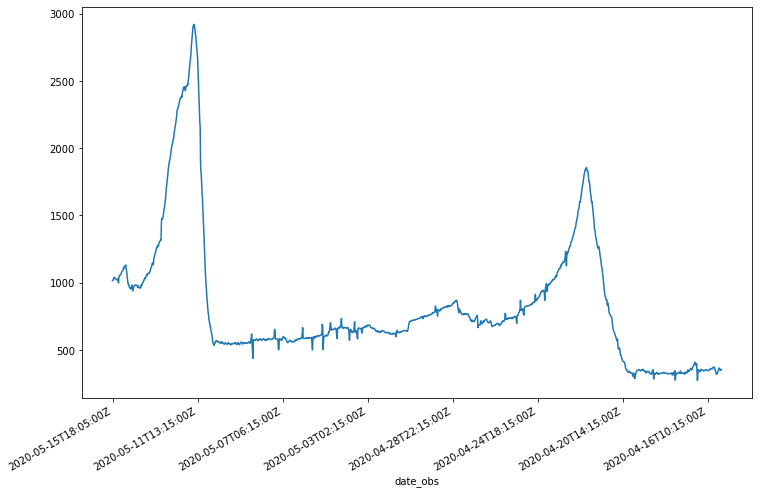

In [16]:
validation_data = read_raw_data("../data/raw/validation_data/hubeau_site_Y1422030_2020-04-15_30d_30m_L'Aude.csv")
validation_data.plot(subplots=True)

We will work with two setups:
* a **single-step** setup where the model learns to predict a single point in the future based on some history provided
* a **multi-step** setup where given a past history the model needs to learn to predict a range of future values 

Let's say you want to predict the water level 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 240 (5x48) observations to train the model if your time step is 30 minutes (2 observations per hour). Many such configurations are possible, making this dataset a good one to experiment with.

The `data_windows` function returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict, ie the label(s) that needs to be predicted: a single value for single-step setup and a set of values for multi-step setup.

We can keep 75% of the training dataset to train and the remaining 25% would be the validation data. However, we prefer to use two really different datasets in order to ensure our model is generalizing correctly to unseen data. We split our validation dataset into two parts, 50% for training validation and 50% we will use to test the model against unseen data.

First we need to standardize the data (i.e. transform data to have a mean of zero and a standard deviation of 1):

In [17]:
from src.data import normalize, denormalize

print('Training dataset length is {}'.format(data.size))
mean = data.values.mean()
std = data.values.std()
print ('Training Mean value {} - Std value {}'.format(mean, std))
ndata = normalize(data.values, mean, std)

print('Validation dataset length is {}'.format(validation_data.size))
vmean = validation_data.values.mean()
vstd = validation_data.values.std()
print ('Validation Mean value {} - Std value {}'.format(vmean, vstd))
nvdata = normalize(validation_data.values, mean, std)

Training dataset length is 1440
Training Mean value 764.8993055555555 - Std value 867.8262052389971
Validation dataset length is 1432
Validation Mean value 822.6382681564246 - Std value 491.7656981039218


## Single-step model

We first start with the single step setup: the model learns to predict a single point in the future based on some history provided. Let's now create the data for the model, it will be given the last N recorded observations (eg 24 observations - 12H if your time step is 30 minutes), and needs to learn to predict the level in Y hours (eg 8 observations - 4H ahead if your time step is 30 minutes).

Timestep 30m - History 12h - Looking 240m ahead
Sample window [-0.17272964 -0.18540499 -0.21075568 -0.23149716 -0.22919256 -0.20499416
 -0.17157733 -0.17157733 -0.19692803 -0.20729877 -0.22804025 -0.23495408
 -0.2395633  -0.25339095 -0.23495408 -0.21075568 -0.18655729 -0.17618655
 -0.18079577 -0.18194807 -0.18540499 -0.19116651 -0.18540499 -0.17964346]
Target level value -0.19692803066310993


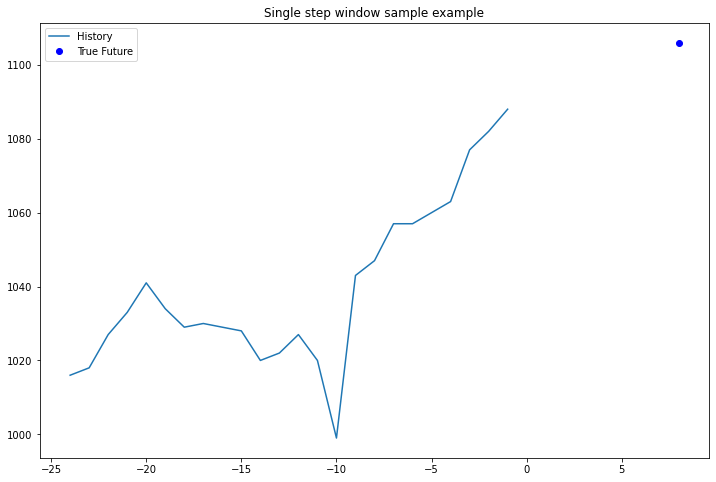

In [19]:
from src.data import data_windows
from src.visualisation import show_single_plot

timestep = 30 # in minutes, can be 10, 30 or 60
perHour = round(60 / timestep) # number of observation per hour
history = (12 * perHour) # N hours history
future = (4 * perHour) # Predict N hours ahead

print ('Timestep {}m - History {}h - Looking {}m ahead'.format(timestep, round(history / perHour), future*timestep))

x_train_single, y_train_single = data_windows(ndata, history, future, single_step=True)
x_validate_single, y_validate_single = data_windows(nvdata, history, future, single_step=True)

print ('Sample window {}'.format(x_train_single[0].flatten()))
print ('Target level value {}'.format(y_train_single[0]))

show_single_plot(x_validate_single[0], y_validate_single[0], future, None, 'Single step window sample example', mean, std)

### Model fitting

In [70]:
# Load model if already fitted, skip otherwise
#model_single = tf.keras.models.load_model("../models/model_single")

We will fit a Recurrent Neural Network (RNN), which is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. In this experiment, we will use a specialized RNN layer called Long Short Term Memory (LSTM).

In [26]:
from src.modelling import fitRNN

(model_single, model_single_history) = fitRNN(x_train_single, y_train_single, x_validate_single, y_validate_single)

Epoch 1/10
100/100 [==============================] - 3s 35ms/step - loss: 0.2343 - mse: 0.3629 - val_loss: 0.1339 - val_mse: 0.1151
Epoch 2/10
100/100 [==============================] - 2s 25ms/step - loss: 0.1288 - mse: 0.1527 - val_loss: 0.1204 - val_mse: 0.0859
Epoch 3/10
100/100 [==============================] - 2s 25ms/step - loss: 0.1200 - mse: 0.1326 - val_loss: 0.1061 - val_mse: 0.0599
Epoch 4/10
100/100 [==============================] - 3s 26ms/step - loss: 0.0982 - mse: 0.0959 - val_loss: 0.1129 - val_mse: 0.0643
Epoch 5/10
100/100 [==============================] - 2s 25ms/step - loss: 0.0858 - mse: 0.0795 - val_loss: 0.0989 - val_mse: 0.0494
Epoch 6/10
100/100 [==============================] - 2s 24ms/step - loss: 0.0809 - mse: 0.0689 - val_loss: 0.0890 - val_mse: 0.0390
Epoch 7/10
100/100 [==============================] - 2s 24ms/step - loss: 0.0723 - mse: 0.0537 - val_loss: 0.0713 - val_mse: 0.0204
Epoch 8/10
100/100 [==============================] - 2s 25ms/step - 

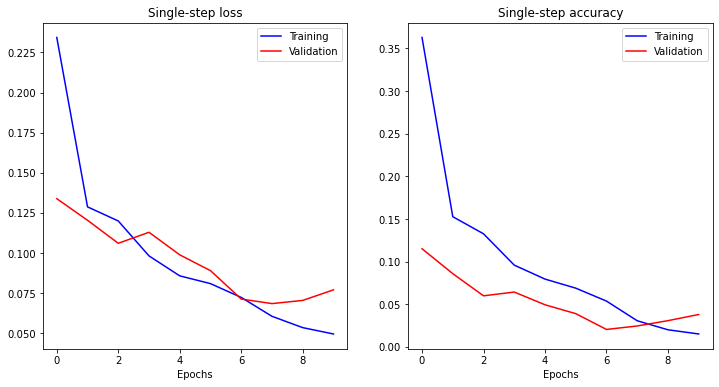

In [27]:
import matplotlib.pyplot as plt
from src.visualisation import plot_train_metric

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_train_metric(model_single_history, 'Single-step loss', 'loss')
plt.subplot(122)
plot_train_metric(model_single_history, 'Single-step accuracy', 'mse')

In Keras the loss is calculated as a moving average over all processed batches, meaning that in the early training stage when loss drops quickly the first batch of an epoch will have a much higher loss than the last. When the epoch is finished, the shown training loss will NOT represent the training loss at the end of the epoch but the average training loss from start to end of the epoch. Therefore, it's often times higher than the validation loss, which is calculated at the end of the epoch entirely.

Fundamental rules:
- validation loss >> training loss => overfitting.
- validation loss  > training loss => some overfitting.
- validation loss  < training loss => some underfitting.
- validation loss << training loss => it underfitting.

Model is fitting very nicely the training data but not at all the validation data when overfitting occurs, in other words it's not generalizing correctly to unseen data. If both losses end up to be roughly the same, and if the values are converging, then chances are very high that we are doing it right.

### Model evaluation

Now see how it performs globally on a flood period:

Mean Absolute Error 31.34
Max Absolute Error 114.18
Mean Absolute Percentage Error 3.11%
Max Absolute Percentage Error 15.57%
Mean Squared Error 2959.17
Root Mean Squared Error 54.40


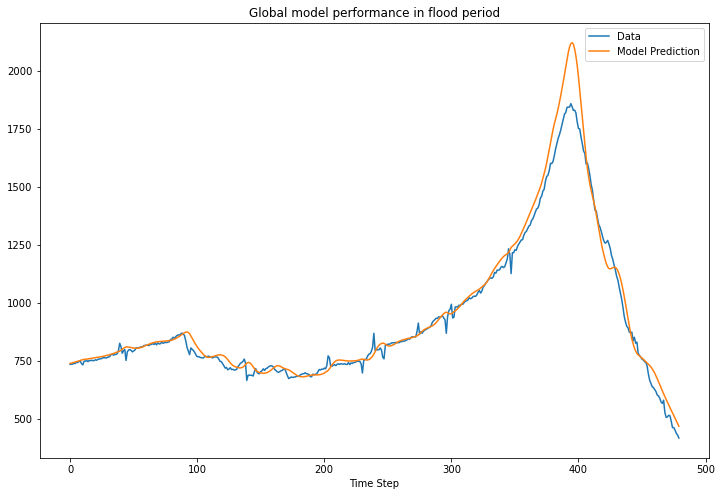

In [28]:
from src.modelling import predictRangeRNN
from src.visualisation import show_prediction

flood_start = 15 * 24 * perHour # 15 days after start period
flood_end = 25 * 24 * perHour # 25 days after start period
ground_truth, prediction = predictRangeRNN(model_single, validation_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance in flood period')

Then see how it performs globally on another station:

Mean Absolute Error 369.21
Max Absolute Error 1804.14
Mean Absolute Percentage Error 17.96%
Max Absolute Percentage Error 92.00%
Mean Squared Error 337730.00
Root Mean Squared Error 581.15


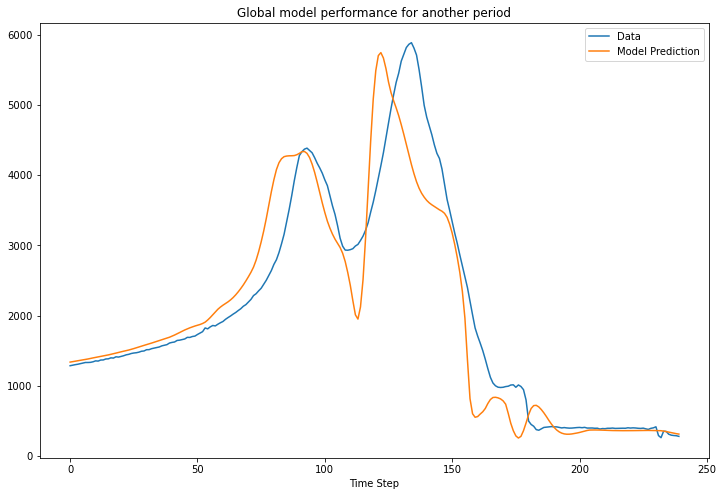

In [31]:
# Data for testing at another but near station
test_data = read_raw_data("../data/raw/train_data/hubeau_site_Y1232010_30d_30m_L'Aude.csv")

flood_start = 12 * 24 * perHour # 12 days after start period
flood_end = 17 * 24 * perHour # 17 days after start period
ground_truth, prediction = predictRangeRNN(model_single, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another period')

And another period:

Mean Absolute Error 32.33
Max Absolute Error 115.39
Mean Absolute Percentage Error 2.82%
Max Absolute Percentage Error 18.70%
Mean Squared Error 3750.77
Root Mean Squared Error 61.24


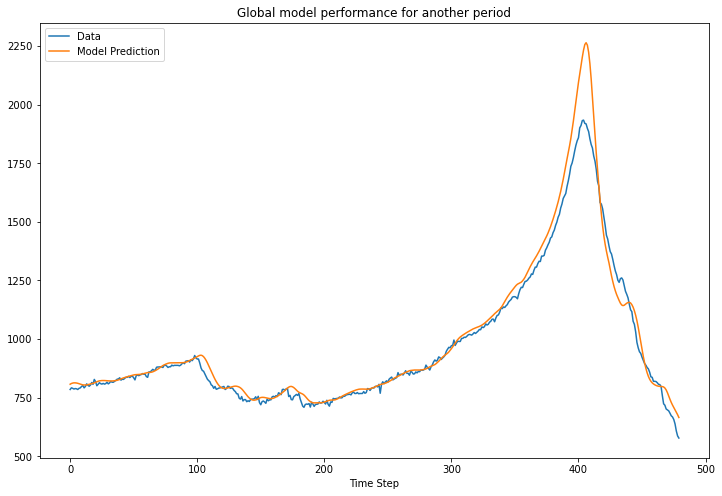

In [32]:
# Data for testing at another but near station
test_data = read_raw_data("../data/raw/validation_data/hubeau_site_Y1232010_2020-04-15_30d_30m_L'Aude.csv")

flood_start = 15 * 24 * perHour # 12 days after start period
flood_end = 25 * 24 * perHour # 17 days after start period
ground_truth, prediction = predictRangeRNN(model_single, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another period')

## Multi-step model

We will then work with the multi-step setup, ie given a past history, the model needs to learn to predict a range of future values. Data setup and model training is pretty similar except since the task here is a bit more complicated than the previous task, the model can consist of more LSTM layers.

Sample window [-0.17272964 -0.18540499 -0.21075568 -0.23149716 -0.22919256 -0.20499416
 -0.17157733 -0.17157733 -0.19692803 -0.20729877 -0.22804025 -0.23495408
 -0.2395633  -0.25339095 -0.23495408 -0.21075568 -0.18655729 -0.17618655
 -0.18079577 -0.18194807 -0.18540499 -0.19116651 -0.18540499 -0.17964346]
Target level value [-0.17964346 -0.17042503 -0.16927272 -0.1635112  -0.17042503 -0.17618655
 -0.18310038 -0.20729877]


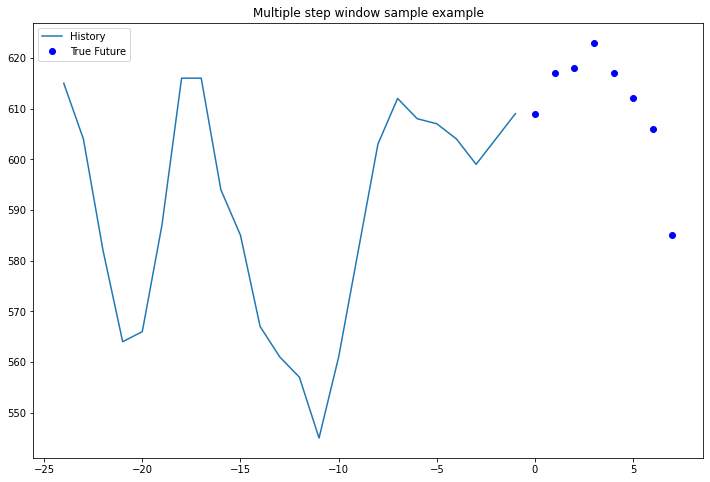

In [37]:
from src.visualisation import show_multiple_plot

x_train_multiple, y_train_multiple = data_windows(ndata, history, future, single_step=False)
x_validate_multiple, y_validate_multiple = data_windows(nvdata, history, future, single_step=False)

print ('Sample window {}'.format(x_train_multiple[0].flatten()))
print ('Target level value {}'.format(y_train_multiple[0]))

show_multiple_plot(x_train_multiple[0], y_train_multiple[0], None, 'Multiple step window sample example', mean, std)

### Model fitting

In [68]:
# Load model if already fitted, skip otherwise
#model_multiple = tf.keras.models.load_model("../models/model_multiple")

In [60]:
from src.modelling import fitRNN

(model_multiple, model_multiple_history) = fitRNN(x_train_multiple, y_train_multiple, x_validate_multiple, y_validate_multiple, future)

Epoch 1/10
100/100 [==============================] - 3s 29ms/step - loss: 0.4898 - mse: 0.7892 - val_loss: 0.2141 - val_mse: 0.1730
Epoch 2/10
100/100 [==============================] - 2s 17ms/step - loss: 0.2851 - mse: 0.3519 - val_loss: 0.1363 - val_mse: 0.0752
Epoch 3/10
100/100 [==============================] - 2s 17ms/step - loss: 0.1710 - mse: 0.1434 - val_loss: 0.0781 - val_mse: 0.0201
Epoch 4/10
100/100 [==============================] - 2s 17ms/step - loss: 0.1035 - mse: 0.0438 - val_loss: 0.0526 - val_mse: 0.0111
Epoch 5/10
100/100 [==============================] - 2s 17ms/step - loss: 0.0705 - mse: 0.0253 - val_loss: 0.0497 - val_mse: 0.0121
Epoch 6/10
100/100 [==============================] - 2s 17ms/step - loss: 0.0549 - mse: 0.0198 - val_loss: 0.0499 - val_mse: 0.0136
Epoch 7/10
100/100 [==============================] - 2s 17ms/step - loss: 0.0524 - mse: 0.0190 - val_loss: 0.0495 - val_mse: 0.0121
Epoch 8/10
100/100 [==============================] - 2s 17ms/step - 

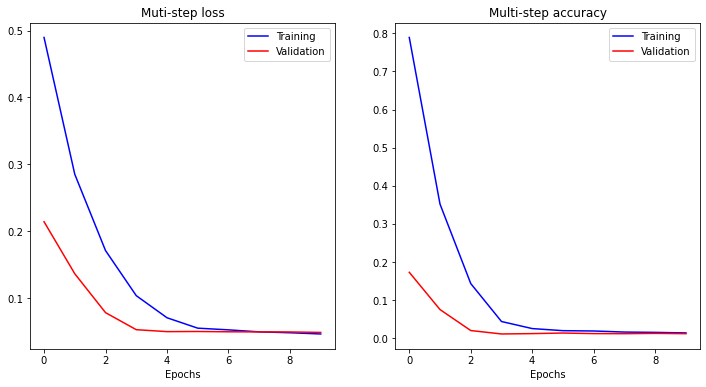

In [61]:
from src.visualisation import plot_train_metric

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_train_metric(model_multiple_history, 'Muti-step loss', 'loss')
plt.subplot(122)
plot_train_metric(model_multiple_history, 'Multi-step accuracy', 'mse')

### Model evaluation

Now see how it performs globally on a flood period:

Mean Absolute Error 22.41
Max Absolute Error 92.01
Mean Absolute Percentage Error 2.66%
Max Absolute Percentage Error 19.34%
Mean Squared Error 1253.43
Root Mean Squared Error 35.40


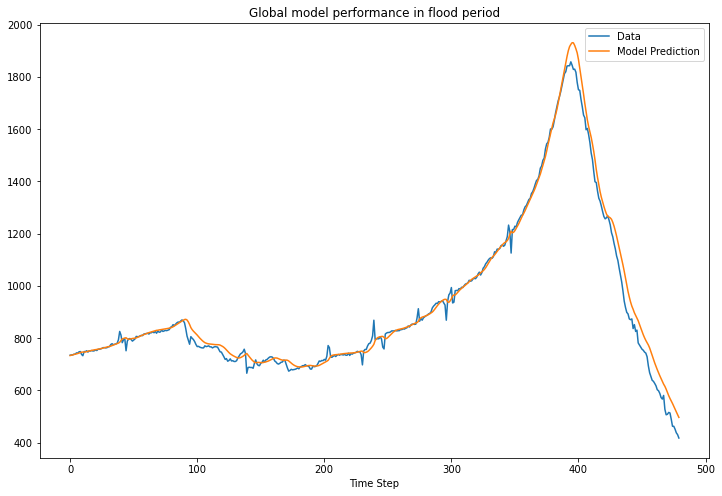

In [69]:
from src.modelling import predictRangeRNN

flood_start = 15 * 24 * perHour # 15 days after start period
flood_end = 25 * 24 * perHour # 25 days after start period
ground_truth, prediction = predictRangeRNN(model_multiple, validation_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance in flood period')

Then see how it performs globally on another station:

Mean Absolute Error 152.31
Max Absolute Error 1050.75
Mean Absolute Percentage Error 9.14%
Max Absolute Percentage Error 96.71%
Mean Squared Error 68028.01
Root Mean Squared Error 260.82


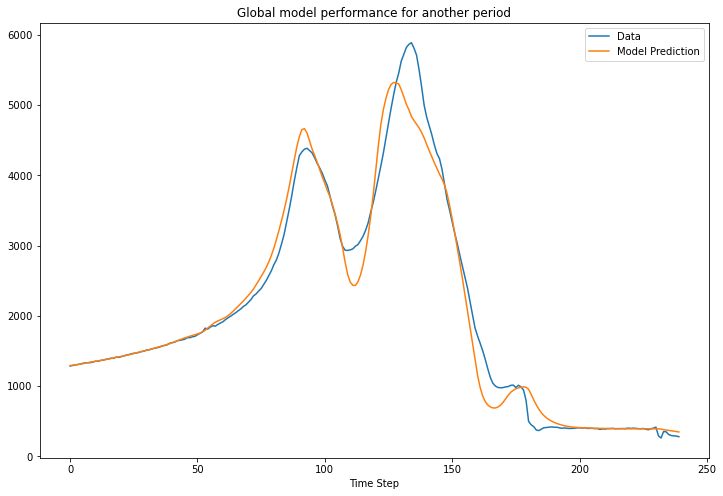

In [63]:
# Data for testing at another but near station
test_data = read_raw_data("../data/raw/train_data/hubeau_site_Y1232010_30d_30m_L'Aude.csv")

flood_start = 12 * 24 * perHour # 12 days after start period
flood_end = 17 * 24 * perHour # 17 days after start period
ground_truth, prediction = predictRangeRNN(model_multiple, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another period')

And another period:

Mean Absolute Error 19.81
Max Absolute Error 24.75
Mean Absolute Percentage Error 2.07%
Max Absolute Percentage Error 16.79%
Mean Squared Error 1073.42
Root Mean Squared Error 32.76


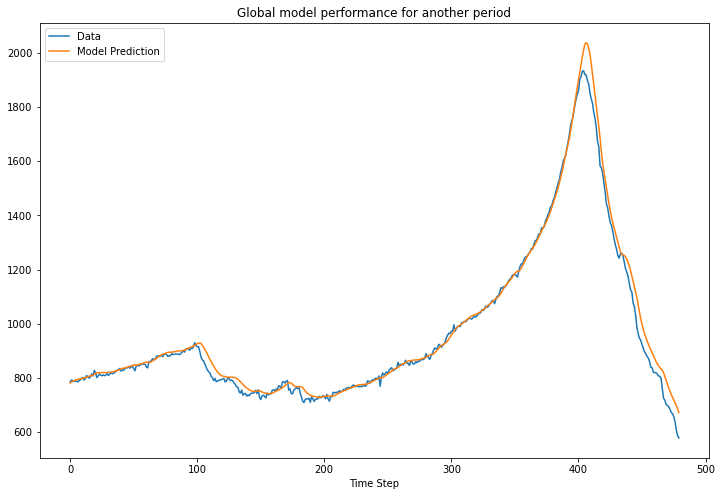

In [64]:
# Data for testing at another but near station
test_data = read_raw_data("../data/raw/validation_data/hubeau_site_Y1232010_2020-04-15_30d_30m_L'Aude.csv")

flood_start = 15 * 24 * perHour # 12 days after start period
flood_end = 25 * 24 * perHour # 17 days after start period
ground_truth, prediction = predictRangeRNN(model_multiple, test_data, history, flood_start, flood_end, mean, std)
show_prediction(ground_truth, prediction, 'Global model performance for another period')

In [66]:
# Save models if we are happy with
model_single.save("../models/model_single")
model_multiple.save("../models/model_multiple")

INFO:tensorflow:Assets written to: ../models/model_single\assets
INFO:tensorflow:Assets written to: ../models/model_multiple\assets
